# 1- Importing libraries

In [59]:
import ast
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from sklearn import metrics 

# 2- Getting real-time crptocurrency data

In [60]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import requests


def run_query(query):  # A simple function to use requests.post to make the API call.
    headers = {'X-API-KEY': 'BQYjLXSsm32NnV6FM4eudu9xYt2L3AsW'}
    request = requests.post('https://graphql.bitquery.io/',
                            json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed and return code is {}.      {}'.format(request.status_code,
                        query))


# The GraphQL query

query = """
query
{
  ethereum(network: ethereum) {
    dexTrades(
      options: {limit: 100000, asc: "timeInterval.minute"}
      date: {since: "2021-04-21"}
      exchangeName: {is: "Uniswap"}
      baseCurrency: {is: "0xdac17f958d2ee523a2206206994597c13d831ec7"}
      quoteCurrency: {is: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"}
    ) {
      timeInterval {
        minute(count: 5)
      }
      baseCurrency {
        symbol
        address
      }
      baseAmount
      quoteCurrency {
        symbol
        address
      }
      quoteAmount
      trades: count
      quotePrice
      maximum_price: quotePrice(calculate: maximum)
      minimum_price: quotePrice(calculate: minimum)
      open_price: minimum(of: block, get: quote_price)
      close_price: maximum(of: block, get: quote_price)
    }
  }
}


"""
result = run_query(query)  # Execute the query


In [61]:
data=pd.DataFrame(result['data']['ethereum']['dexTrades'])
data.tail(2)

,timeInterval,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
7689,{'minute': '2021-05-17 16:45:00'},"{'symbol': 'USDT', 'address': '0xdac17f958d2ee...",888144.479345,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",273.847796,49,0.000308,0.00031,0.000306,0.0003076480217179776,0.00030994409765602914
7690,{'minute': '2021-05-17 16:50:00'},"{'symbol': 'USDT', 'address': '0xdac17f958d2ee...",99721.073893,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",30.747842,14,0.000308,0.00031,0.000308,0.00030996224013209227,0.00030795038344018475


# 3- Data cleaning

In [62]:
data.isnull().sum()

timeInterval     0
baseCurrency     0
baseAmount       0
quoteCurrency    0
quoteAmount      0
trades           0
quotePrice       0
maximum_price    0
minimum_price    0
open_price       0
close_price      0
dtype: int64

In [63]:
time=[]
for x in range(0, data.shape[0]):
    time.append(data['timeInterval'].iloc[x]['minute'])
    
data['timeInterval']= time
data.head(2)

,timeInterval,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
0,2021-04-21 00:00:00,"{'symbol': 'USDT', 'address': '0xdac17f958d2ee...",235430.276677,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",100.644624,26,0.000427,0.000429,0.000426,0.00042685698850960943,0.00042639083118730357
1,2021-04-21 00:05:00,"{'symbol': 'USDT', 'address': '0xdac17f958d2ee...",125045.994789,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",53.568555,23,0.000428,0.000429,0.000426,0.00042651155228814547,0.0004266924808575541


In [64]:
type(data['close_price'].iloc[0])

str

In [65]:
data['close_price']= data['close_price'].apply(lambda x: float(x))

In [66]:
type(data['close_price'].iloc[0])

numpy.float64

# 4- Setting time as index

In [67]:
data=data.set_index('timeInterval')
data.head(2)

,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
timeInterval,,,,,,,,,,
2021-04-21 00:00:00,"{'symbol': 'USDT', 'address': '0xdac17f958d2ee...",235430.276677,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",100.644624,26,0.000427,0.000429,0.000426,0.00042685698850960943,0.000426
2021-04-21 00:05:00,"{'symbol': 'USDT', 'address': '0xdac17f958d2ee...",125045.994789,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",53.568555,23,0.000428,0.000429,0.000426,0.00042651155228814547,0.000427


# 5- Converting time to timestamp

In [68]:
type(data.index[0])

str

In [69]:
data.index=pd.to_datetime(data.index)

In [70]:
type(data.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [71]:
data.shape

(7691, 10)

# 6- Splitting train & test sets

In [72]:
def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set =train_test_split(data, 0.3)    #checked test size 0.2 but the result for 0.3 is better
print('train_set.shape: ', train_set.shape)
print('test_set.shape: ', test_set.shape)

train_set.shape:  (5384, 10)
test_set.shape:  (2307, 10)


# 7- Plotting train & test sets

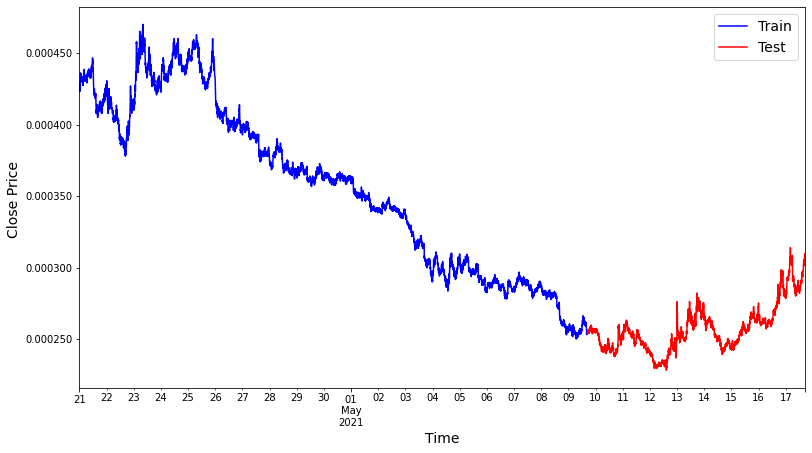

In [73]:
plt.figure(figsize=(13,7))
train_set['close_price'].plot(color='b')
test_set['close_price'].plot(color='r')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Close Price ', fontsize=14)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.6f}')) 
plt.legend(['Train', 'Test'], loc='best',fontsize=14 )
plt.show()

# 9- Normalizing data- zero scaling

In [74]:
def zero_scaling(df):
    
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):
    
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(df, column, len_window, zero):
    
    train_data = train_set[[column]]
    test_data = test_set[[column]]
        
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 

    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values

    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1

    return train_data,  test_data, X_train, X_test,  y_train, y_test

In [75]:
train_data, test_data, X_train, X_test,  y_train, y_test = prepare_data(data, 'close_price', len_window=5, zero=True)

In [76]:
X_train.shape

(5379, 5, 1)

# 10- Building LSTM model- 2 layers

In [77]:
model_1 = Sequential()
                                   
#use  input_shape (tuple of integers) when using this layer as the first layer in a model

model_1.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
model_1.add(Dropout(0.2))


model_1.add(Dense(units=1 ))  # tedade noroun ha
model_1.add(Activation('linear'))  #activation ra besoorate layer joda add konim natije behtar ast

model_1.compile(loss='mse', optimizer='adam')

In [78]:
# Fitting to the training set
model_1.fit(X_train,y_train,epochs=30,batch_size=32) 

Epoch 1/30
169/169 [==============================] - 2s 4ms/step - loss: 5.4025e-05
Epoch 2/30
169/169 [==============================] - 1s 4ms/step - loss: 2.6913e-05
Epoch 3/30
169/169 [==============================] - 1s 4ms/step - loss: 2.7016e-05
Epoch 4/30
169/169 [==============================] - 1s 4ms/step - loss: 2.6887e-05
Epoch 5/30
169/169 [==============================] - 1s 3ms/step - loss: 2.3906e-05
Epoch 6/30
169/169 [==============================] - 1s 4ms/step - loss: 2.3446e-05
Epoch 7/30
169/169 [==============================] - 1s 4ms/step - loss: 2.4683e-05
Epoch 8/30
169/169 [==============================] - 1s 5ms/step - loss: 2.3066e-05
Epoch 9/30
169/169 [==============================] - 1s 4ms/step - loss: 2.4230e-05A: 0s - los
Epoch 10/30
169/169 [==============================] - 1s 4ms/step - loss: 2.3756e-05
Epoch 11/30
169/169 [==============================] - 1s 4ms/step - loss: 2.3560e-05
Epoch 12/30
169/169 [==============================]

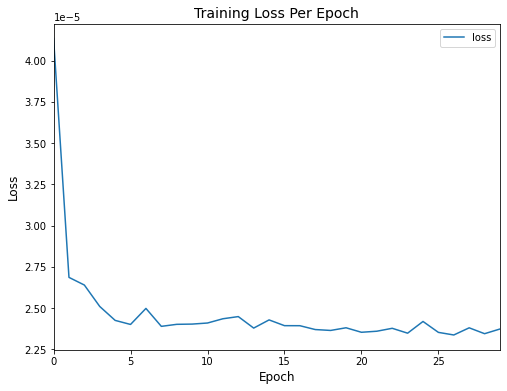

In [79]:
pd.DataFrame(model_1.history.history).plot(figsize=(8,6))
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Per Epoch', fontsize=14)
plt.show()

In [80]:
prediction_1=model_1.predict(X_test).squeeze()  # use squeeze to convert to 1d array 

In [81]:
assert (len(prediction_1)==len(y_test))

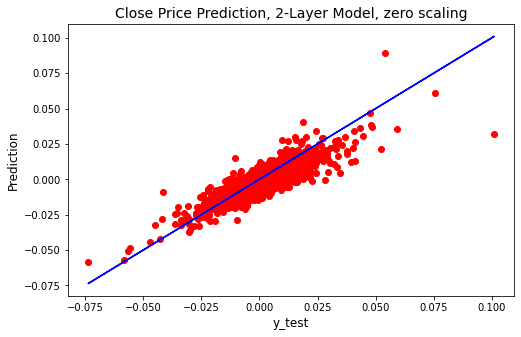

In [82]:
plt.figure(figsize=(8,5))
plt.plot(y_test, y_test, color='b')
plt.scatter(y_test, prediction_1, color='r')
plt.xlabel('y_test', fontsize=12)
plt.ylabel('Prediction', fontsize=12)
plt.title('Close Price Prediction, 2-Layer Model, zero scaling', fontsize=14)
plt.show()

In [83]:
print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, prediction_1))

Mean Absolute Error:  0.0046765956125725625


In [84]:
predicted_close_price_1= pd.DataFrame(data=(prediction_1 + 1) * (test_data['close_price'][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_close_price'] )
predicted_close_price_1;

merged_1=pd.merge(test_data, predicted_close_price_1, on='timeInterval', how='left')
merged_1[5:]

,close_price,predicted_close_price
timeInterval,,
2021-05-09 17:05:00,0.000255,0.000254
2021-05-09 17:10:00,0.000256,0.000255
2021-05-09 17:15:00,0.000254,0.000255
2021-05-09 17:20:00,0.000254,0.000254
2021-05-09 17:25:00,0.000254,0.000254
...,...,...
2021-05-17 16:30:00,0.000306,0.000302
2021-05-17 16:35:00,0.000305,0.000305
2021-05-17 16:40:00,0.000306,0.000304


In [85]:
merged_1.isnull().sum()

close_price              0
predicted_close_price    5
dtype: int64

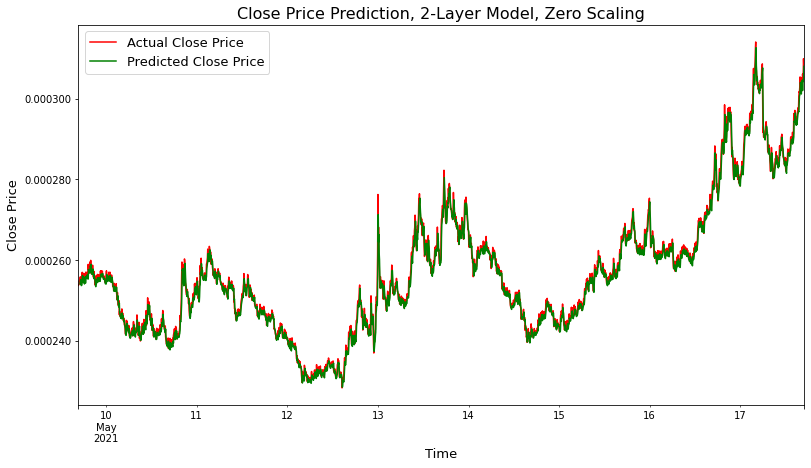

In [86]:
plt.figure(figsize=(13,7))
merged_1['close_price'].plot(color='r')
merged_1['predicted_close_price'].plot(color='g')
plt.title('Close Price Prediction, 2-Layer Model, Zero Scaling',fontsize=16)
plt.xlabel('Time', fontsize=13)
plt.ylabel('Close Price', fontsize=13)
plt.legend(['Actual Close Price', 'Predicted Close Price'], loc='best',fontsize=13)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.6f}')) 
plt.show()

# 11- Predicting on brand new data

In [87]:
#size of the data we use to predict should always be at least one unit bigger than window_len
from random import randint

def rand(len_window, df):
    return randint(len_window + 1 , df.shape[0])

In [88]:
random_shape=rand(5, data)
random_shape

4769

In [89]:
new=data[['close_price']].iloc[0:  random_shape]
sliding_window(new, 5, True);
prediction=model_1.predict(sliding_window(new, 5, True)).squeeze()
assert(len(prediction)==len( new['close_price'][:-5]))
predicted_close_price= pd.DataFrame(data=(prediction + 1) * (new['close_price'][:-5].values) ,  index=new[5:].index ,columns=['predicted close'] )
pd.merge(new, predicted_close_price, on='timeInterval', how='left')[5:]

,close_price,predicted close
timeInterval,,
2021-04-21 00:25:00,0.000424,0.000423
2021-04-21 00:30:00,0.000426,0.000423
2021-04-21 00:35:00,0.000429,0.000425
2021-04-21 00:40:00,0.000427,0.000428
2021-04-21 00:45:00,0.000433,0.000426
...,...,...
2021-05-07 13:00:00,0.000286,0.000285
2021-05-07 13:05:00,0.000287,0.000286
2021-05-07 13:10:00,0.000285,0.000286


# 12- Backup scenarios

### 12-1-  LSTM model- 6 layers + zero scaling

In [90]:
# The LSTM architecture
model_2 = Sequential()

# First LSTM layer with Dropout regularisation
#default activation` == `tanh`
#default recurrent_activation == sigmoid.
 #return_sequences: Boolean. Whether to return the last output.Default: `False`.

model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model_2.add(Dropout(0.2))

# Second LSTM layer
model_2.add(LSTM(units=50, return_sequences=True))
model_2.add(Dropout(0.2))

# Third LSTM layer
model_2.add(LSTM(units=50, return_sequences=True))
model_2.add(Dropout(0.2))


# Fourth LSTM layer
model_2.add(LSTM(units=50))
model_2.add(Dropout(0.2))


# The output layer
model_2.add(Dense(units=1))


# Compiling the RNN
model_2.compile(optimizer='rmsprop',loss='mean_squared_error')

In [91]:
# Fitting to the training set
model_2.fit(X_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
169/169 [==============================] - 10s 13ms/step - loss: 1.1318e-04
Epoch 2/30
169/169 [==============================] - 2s 12ms/step - loss: 8.2664e-05
Epoch 3/30
169/169 [==============================] - 2s 12ms/step - loss: 8.0822e-05: 0s - loss: 8.08
Epoch 4/30
169/169 [==============================] - 2s 11ms/step - loss: 7.5970e-05
Epoch 5/30
169/169 [==============================] - 2s 12ms/step - loss: 4.7306e-05
Epoch 6/30
169/169 [==============================] - 2s 11ms/step - loss: 3.9225e-05
Epoch 7/30
169/169 [==============================] - 2s 11ms/step - loss: 3.3716e-05
Epoch 8/30
169/169 [==============================] - 2s 11ms/step - loss: 3.0943e-05
Epoch 9/30
169/169 [==============================] - 2s 11ms/step - loss: 3.1280e-05
Epoch 10/30
169/169 [==============================] - 2s 11ms/step - loss: 3.0644e-05
Epoch 11/30
169/169 [==============================] - 2s 11ms/step - loss: 2.9484e-05
Epoch 12/30
169/169 [=============

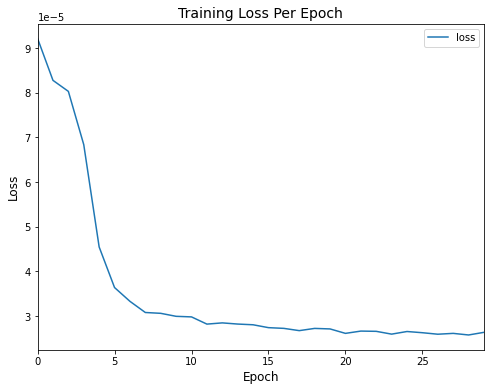

In [92]:
pd.DataFrame(model_2.history.history).plot(figsize=(8,6))
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Per Epoch', fontsize=14)
plt.show()

In [93]:
prediction_2=model_2.predict(X_test).squeeze()  # use squeeze to convert to 1d array 

assert (len(prediction_2)==len(y_test))

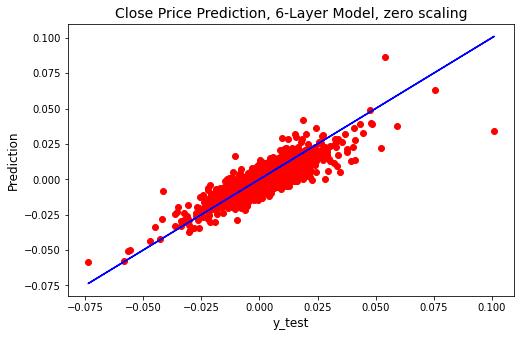

In [94]:
plt.figure(figsize=(8,5))
plt.plot(y_test, y_test, color='b')
plt.scatter(y_test, prediction_2, color='r')
plt.xlabel('y_test', fontsize=12)
plt.ylabel('Prediction', fontsize=12)
plt.title('Close Price Prediction, 6-Layer Model, zero scaling', fontsize=14)
plt.show()

In [95]:
print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, prediction_2))

Mean Absolute Error:  0.00454281633726031


In [96]:
predicted_close_price_2= pd.DataFrame(data=(prediction_2 + 1) * (test_data['close_price'][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_close_price'] )
predicted_close_price_2;

merged_2=pd.merge(test_data, predicted_close_price_2, on='timeInterval', how='left')
merged_2;

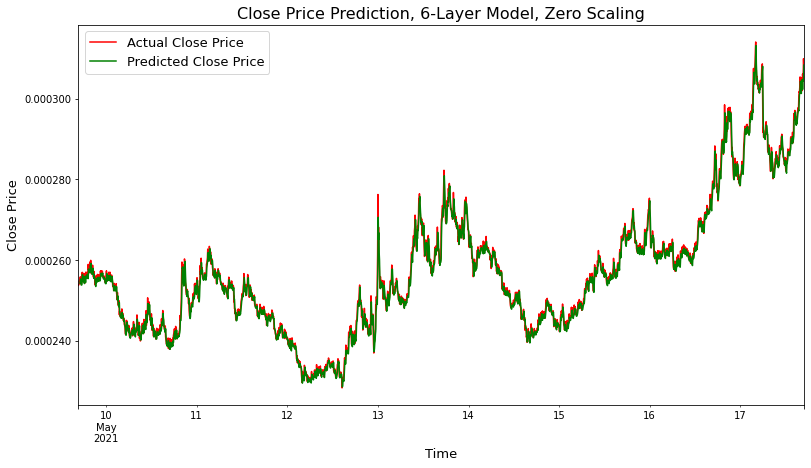

In [97]:
plt.figure(figsize=(13,7))
merged_2['close_price'].plot(color='r')
merged_2['predicted_close_price'].plot(color='g')
plt.title('Close Price Prediction, 6-Layer Model, Zero Scaling',fontsize=16)
plt.xlabel('Time', fontsize=13)
plt.ylabel('Close Price', fontsize=13)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.6f}')) 
plt.legend(['Actual Close Price', 'Predicted Close Price'], loc='best',fontsize=13)
plt.show()

### 12-2- LSTM model- 2 layers + MinMaxScaler

In [98]:
train_data = train_set[['close_price']]
test_data = test_set[['close_price']]

train_data_values=train_data.values
test_data_values=test_data.values

In [99]:
#Scaling/Normalizing the whole Training set
sc = MinMaxScaler(feature_range=(0,1))
train_data_values_scaled = sc.fit_transform(train_data_values)

In [100]:
# Since LSTMs store long term memory state, we create a data structure with 5 timesteps and 1 output
# So for each element of training set, we have 5 previous training set elements 

X_train = []
y_train = []
for i in range(5,train_data_values.shape[0]):
    X_train.append(train_data_values_scaled[i-5:i,0])  #window up to
    y_train.append(train_data_values_scaled[i,0])        #one value after the window
X_train, y_train = np.array(X_train), np.array(y_train)

In [101]:
print(X_train.shape)
print(y_train.shape)

(5379, 5)
(5379,)


In [102]:
# Reshaping X_train for efficient modelling
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_train.shape

(5379, 5, 1)

In [103]:
model_3 = Sequential()
                                   
#use input_shape (tuple of integers) when using this layer as the first layer in a model

model_3.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
model_3.add(Dropout(0.2))

model_3.add(Dense(units=1 ))  
model_3.add(Activation('linear'))  

model_3.compile(loss='mse', optimizer='adam')

In [104]:
# Fitting to the training set
model_3.fit(X_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
169/169 [==============================] - 3s 4ms/step - loss: 0.0670
Epoch 2/30
169/169 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 3/30
169/169 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 4/30
169/169 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 5/30
169/169 [==============================] - 1s 4ms/step - loss: 9.6664e-04
Epoch 6/30
169/169 [==============================] - 1s 4ms/step - loss: 9.5423e-04
Epoch 7/30
169/169 [==============================] - 1s 4ms/step - loss: 8.9271e-04
Epoch 8/30
169/169 [==============================] - 1s 4ms/step - loss: 8.5956e-04
Epoch 9/30
169/169 [==============================] - 1s 4ms/step - loss: 8.2921e-04
Epoch 10/30
169/169 [==============================] - 1s 5ms/step - loss: 8.9536e-04
Epoch 11/30
169/169 [==============================] - 1s 4ms/step - loss: 8.2570e-04
Epoch 12/30
169/169 [==============================] - 1s 4ms/step - loss: 7.95

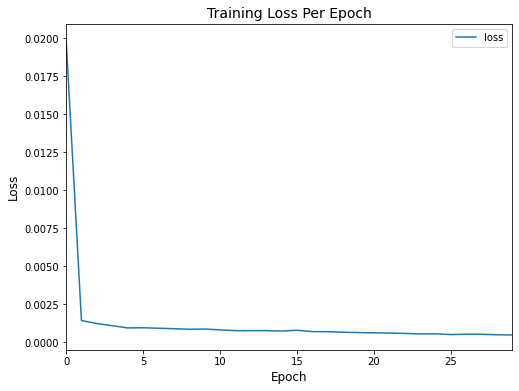

In [105]:
pd.DataFrame(model_3.history.history).plot(figsize=(8,6))
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Per Epoch', fontsize=14)
plt.show()

In [106]:
test_data_values_scaled = sc.fit_transform(test_data_values)  # we only do transfrom on test set not fit

In [107]:
X_test = []
y_test = []
for i in range(5,test_set.shape[0]):
    X_test.append(test_data_values_scaled[i-5:i,0])  #yek panjereh ja tayi ta sare
    y_test.append(test_data_values_scaled[i,0])        #tak element bade panjere
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape

(2302, 5)

In [108]:
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X_test.shape

(2302, 5, 1)

In [109]:
prediction_3=model_3.predict(X_test)  #do not use squeeze, otherwise will get error in inverse scaler
assert (len(prediction_3)==len(y_test))

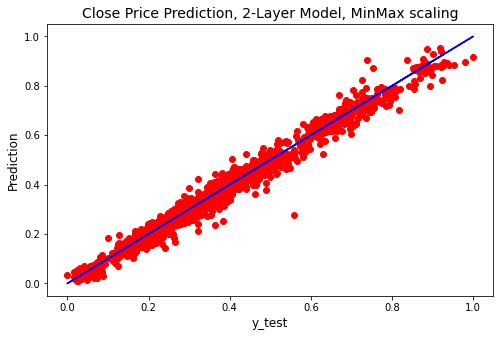

In [110]:
plt.figure(figsize=(8,5))
plt.plot(y_test, y_test, color='b')
plt.scatter(y_test, prediction_3, color='r')
plt.xlabel('y_test', fontsize=12)
plt.ylabel('Prediction', fontsize=12)
plt.title('Close Price Prediction, 2-Layer Model, MinMax scaling', fontsize=14)
plt.show()

In [111]:
print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, prediction_3))

Mean Absolute Error:  0.01792423254519052


In [112]:
predicted_close_price_3 = sc.inverse_transform(prediction_3)

predicted_close_price_3= pd.DataFrame(data= predicted_close_price_3,  index=test_set[5:].index ,columns=['predicted_close_price'] )
predicted_close_price_3;

In [113]:
merged_3=pd.merge(test_data, predicted_close_price_3, on='timeInterval', how='left')
merged_3

,close_price,predicted_close_price
timeInterval,,
2021-05-09 16:40:00,0.000254,NaN
2021-05-09 16:45:00,0.000254,NaN
2021-05-09 16:50:00,0.000254,NaN
2021-05-09 16:55:00,0.000255,NaN
2021-05-09 17:00:00,0.000255,NaN
...,...,...
2021-05-17 16:30:00,0.000306,0.000304
2021-05-17 16:35:00,0.000305,0.000304
2021-05-17 16:40:00,0.000306,0.000304


In [114]:
merged_3.isnull().sum()

close_price              0
predicted_close_price    5
dtype: int64

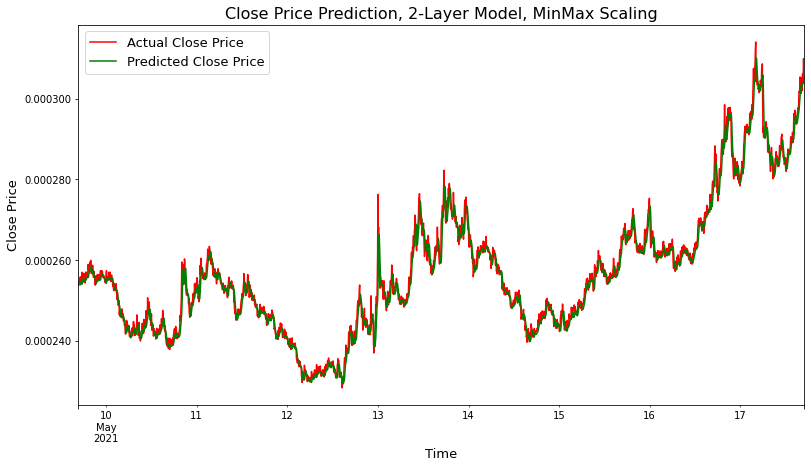

In [115]:
plt.figure(figsize=(13,7))
merged_3['close_price'].plot(color='r')
merged_3['predicted_close_price'].plot(color='g')
plt.title('Close Price Prediction, 2-Layer Model, MinMax Scaling',fontsize=16)
plt.xlabel('Time', fontsize=13)
plt.ylabel('Close Price', fontsize=13)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.6f}')) 
plt.legend(['Actual Close Price', 'Predicted Close Price'], loc='best',fontsize=13)
plt.show()

# 13- Conclusion

Based on the Mean Absolute Error values and Close Price Prediction plots, the 2-layer predictive model executed on the data normalized by zero_scaling function has the best performance.